<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/plot_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import math
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


✅ Found 17 runs. Cleaning and plotting...
Cleaned multi-run file: no_struct_veg_mask_all_crowns
Cleaned multi-run file: no_struct_veg_mask_one_class
Cleaned multi-run file: no_struct_veg_mask_ignore_region
Cleaned multi-run file: no_struct_veg_mask_one_class_dice_loss
Cleaned multi-run file: no_struct_veg_mask_all_crowns_dice_loss
Cleaned multi-run file: no_struct_veg_mask_ignore_region_test
Cleaned multi-run file: no_struct_veg_mask_one_class_dice_loss_25
Cleaned multi-run file: no_struct_veg_mask_ignore_region_25
Cleaned multi-run file: no_struct_veg_mask_all_crowns_dice_loss_experiment_lr_0.001
Cleaned multi-run file: no_struct_veg_mask_all_crowns_dice_loss_experiment_lr_0.0025
Cleaned multi-run file: no_struct_veg_mask_all_crowns_dice_loss_experiment_lr_0.005
Cleaned multi-run file: no_struct_veg_mask_all_crowns_dice_loss_experiment_lr_0.0025_0.3_0.7

Plot saved as cleaned_loss_curves.png


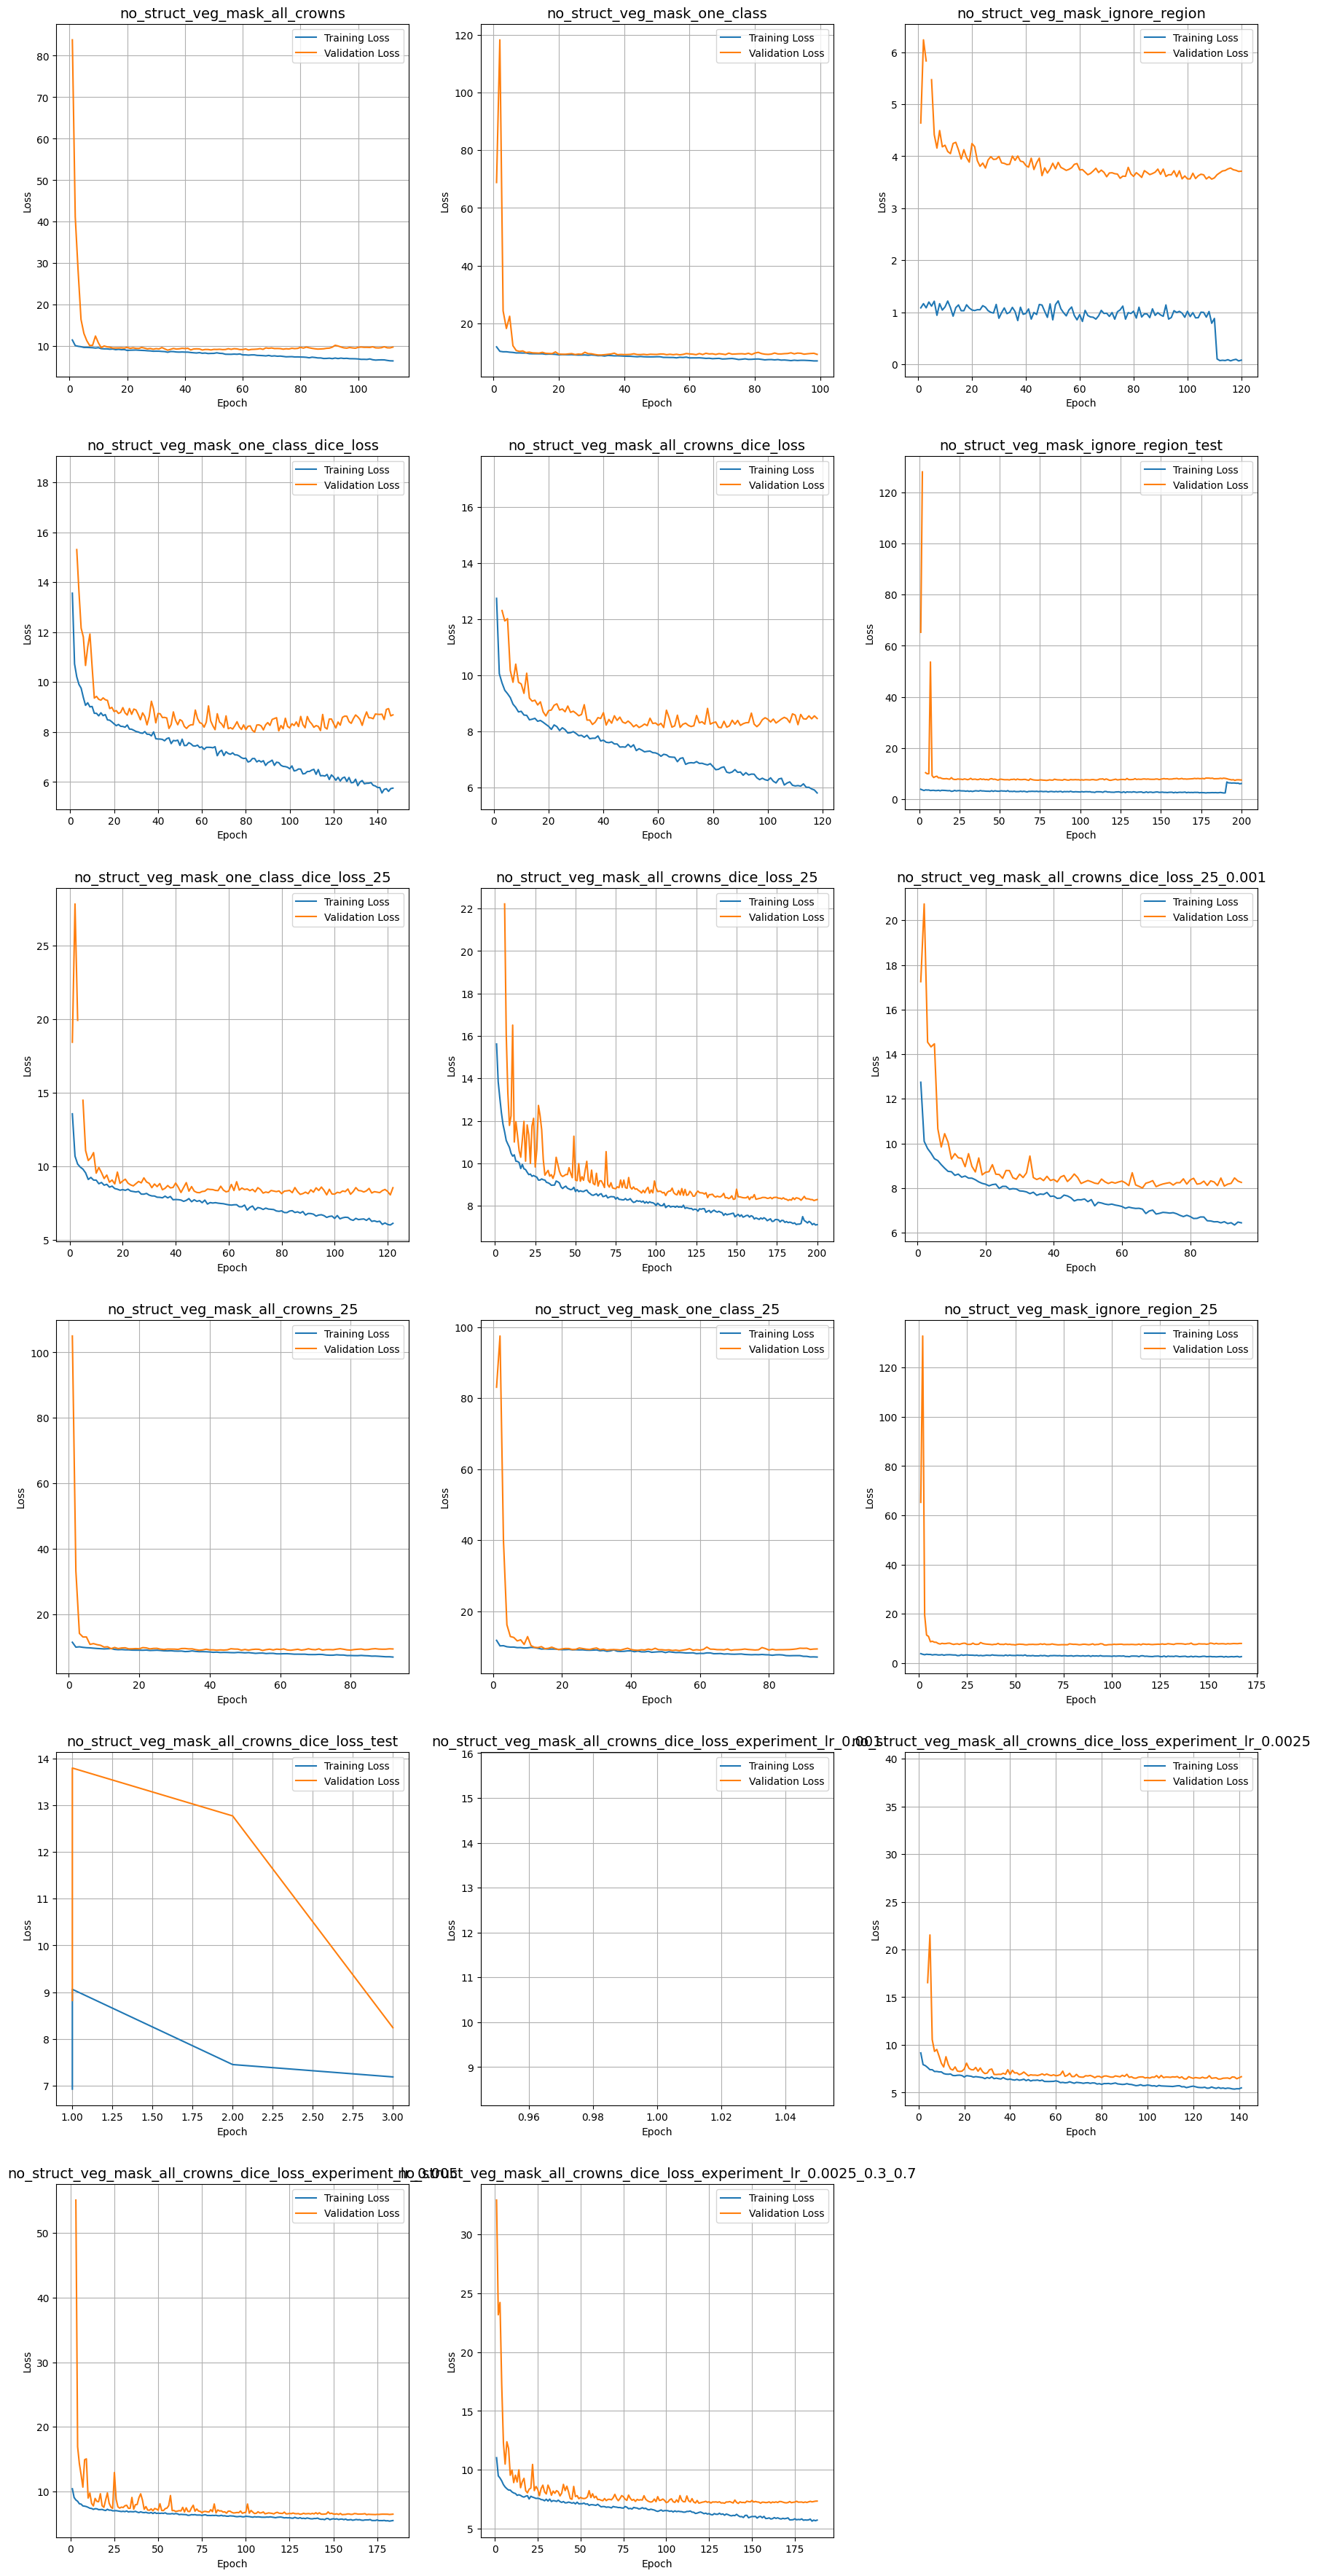

In [ ]:
base_path = '/content/drive/MyDrive/masterthesis/data/runs'
search_pattern = os.path.join(base_path, '**/results.csv')
csv_files = glob.glob(search_pattern, recursive=True)

if not csv_files:
    print(f"⚠️ No 'results.csv' files found in any subdirectories of: {base_path}")
else:
    print(f"✅ Found {len(csv_files)} runs. Cleaning and plotting...")

    # 4. Dynamically create subplots
    num_files = len(csv_files)
    num_cols = min(num_files, 3)
    num_rows = math.ceil(num_files / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows), squeeze=False)
    axes = axes.flatten()

    for i, file_path in enumerate(csv_files):
        try:
            df = pd.read_csv(file_path)

            resets = df['epoch'].diff() < 0
            if resets.any():
                # Find the index of the *last* time a reset occurred.
                last_reset_index = resets[resets].index[-1]
                # Keep only the data from that point forward.
                df = df.loc[last_reset_index:].reset_index(drop=True)
                print(f"Cleaned multi-run file: {os.path.basename(os.path.dirname(file_path))}")

            df.columns = df.columns.str.strip()

            # Extract model name and get the plot title
            model_name = os.path.basename(os.path.dirname(file_path))
            plot_title = model_name

            # Calculate total losses
            train_loss = df['train/box_loss'] + df['train/seg_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
            val_loss = df['val/box_loss'] + df['val/seg_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

            # Plotting the cleaned data
            axes[i].plot(df['epoch'], train_loss, label='Training Loss')
            axes[i].plot(df['epoch'], val_loss, label='Validation Loss')
            axes[i].set_title(plot_title, fontsize=14)
            axes[i].set_xlabel('Epoch')
            axes[i].set_ylabel('Loss')
            axes[i].legend()
            axes[i].grid(True)

        except Exception as e:
            print(f"Could not process file {file_path}. Error: {e}")
            model_name = os.path.basename(os.path.dirname(file_path))
            axes[i].set_title(f'Failed to load: {model_name}')

    # Hide any unused subplots
    for j in range(num_files, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=3.0)
    plt.savefig('cleaned_loss_curves.png')
    print("\nPlot saved as cleaned_loss_curves.png")
    plt.show()